## Capacitated Vehicle Routing Problem

>**Given** A fleet of identical vehicles, with limited capacity, located at a depot; $n$ customers that require service with known demand; cost of travel between any pair of customers, or between any customer and the depot.

>**Find** A minimum-cost collection of vehicle routes, each starting and ending at the depot, such that each customer is visited by exactly one vehicle, and no vehicle visits a set of customers whose total demand exceeds the vehicle capacity.

Let $G=(V,A)$ be a directed graph with node $1$ representing the depot and $V_C=V\setminus{1}$ representing the customers.
The (positive integer) demand of customer $i \in V_C$ is denoted by $q_i$.
For any set of customer $S \subset V_C$ let $q(S)=\sum_{i \in S} q_i$.


### Single commodity flow formulation

Define a continuous variable $f_{ij}$ for each arc $(i,j) \in A$ representing the load (flow) 
carried from $i$ to $j$. The rounded capacity inequalities can be replaced with:

$$
\sum_{j \in \delta^-(i)} f_{ji} - \sum_{j \in \delta^+(i)} f_{ij} = q_i \forall i \in V_C\\
0 \le f_{ij} \le Q x_{ij}
$$

### Strengthening

$$q_j x_{ij} \le f_{ij} \le (Q-q_i) x_{ij} \;\; \forall (i,j) \in A$$

In [1]:
#!/usr/bin/env python


import networkx as nx
import gurobipy as gb
import pygraphviz as pygv
import argparse
from argparse import ArgumentTypeError
import pygraphviz as pygv
import os
from itertools import combinations
from IPython.display import SVG, display



In [2]:
#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(directed='true',strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == depot:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()


def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos,fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sol.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

def DrawSubtour (x, subtour):
    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i in subtour:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true', style='filled')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sub.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()


    
class args:
    filename = None
    scale = 30
    capacity = 5000

G has 15 nodes and 210 edges


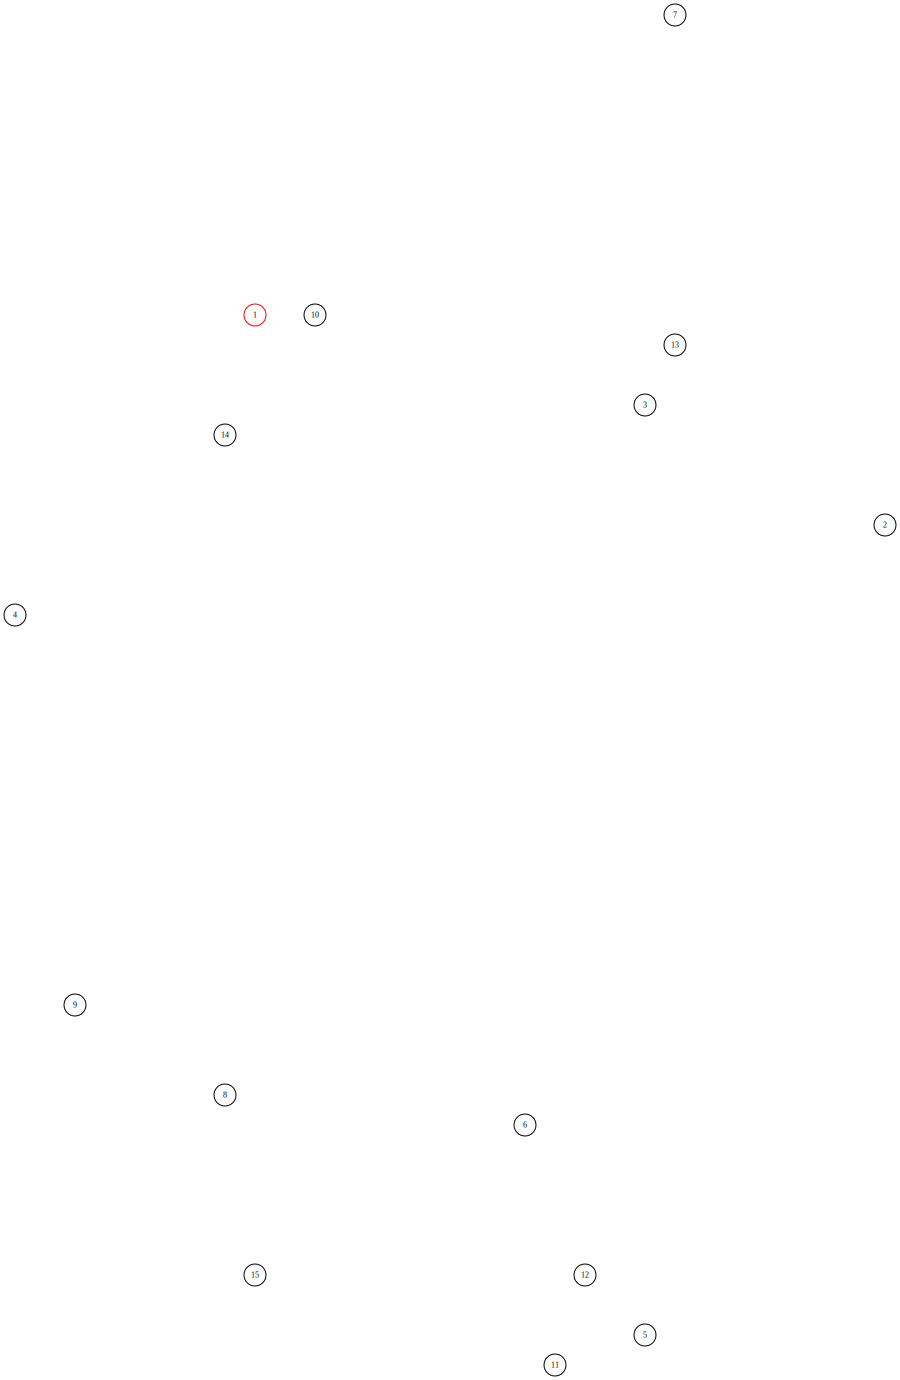

G has 15 nodes and 210 edges


In [3]:
# 
# Read the graph in the graphML format
#

args.filename = 'cvrp.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

depot = list(G.nodes())[0]

DrawInitialGraph()

display(SVG(filename=basename+'.svg'))

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

DrawInitialGraph()

## *Q* is the vehicle capacity 

In [19]:
cvrp = gb.Model("CVRP formulation")

Q = 3000 #vehicle capacity 

## *dem* is the dictionary containing customers requests

In [20]:
dem = nx.get_node_attributes (G,'demand')

depot = 1

dem[depot] = 0 ## Depot does not require service

In [21]:
x = cvrp.addVars(G.edges(), \
                 obj=[G[i][j]['dist'] \
                      for i,j in G.edges()], \
                 vtype = gb.GRB.BINARY, name='x')



#
# Flow variables
#


f = cvrp.addVars (G.edges(), obj=0.0, lb=0, \
    ub=Q, vtype=gb.GRB.CONTINUOUS, name='f')

#
# Assignment constraints
#

#
# Forward star
#

cvrp.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() \
                 if i != depot), name='FS')



# Reverse star
#

cvrp.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()\
                 if i != depot), name='RS')


#
# Flow constraints
#

cvrp.addConstrs((f.sum('*',i) - f.sum(i,'*') \
                 == dem[i] \
                 for i in G.nodes() if i != depot),\
               name='FLOW')

cvrp.addConstrs((f[i,j] <= (Q - dem[i]) * x[i,j] \
                 for i,j in G.edges()),name='VUB')

cvrp.addConstrs((f[i,j] >= dem[j] * x[i,j] \
                 for i,j in G.edges()),name='VLB')

cvrp.update()

In [22]:
cvrp.optimize()
cvrp.write('cvrp.lp')

Optimize a model with 462 rows, 420 columns and 1610 nonzeros
Variable types: 210 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 56 rows and 42 columns
Presolve time: 0.01s
Presolved: 406 rows, 378 columns, 1462 nonzeros
Variable types: 196 continuous, 182 integer (182 binary)
Found heuristic solution: objective 60655.000000

Root relaxation: objective 2.248482e+04, 415 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 22484.8203    0   25 60655.0000 22484.8203  62.9%     -    0s
H    0     0                    33120.000000 22484.8203  32.1%     -    0s
H    0     0                    30360.000000 22484.8203  25.9%     -    0s
H    0     0                    26047.000000 22484.8203  1

In [23]:
DrawSol(x)

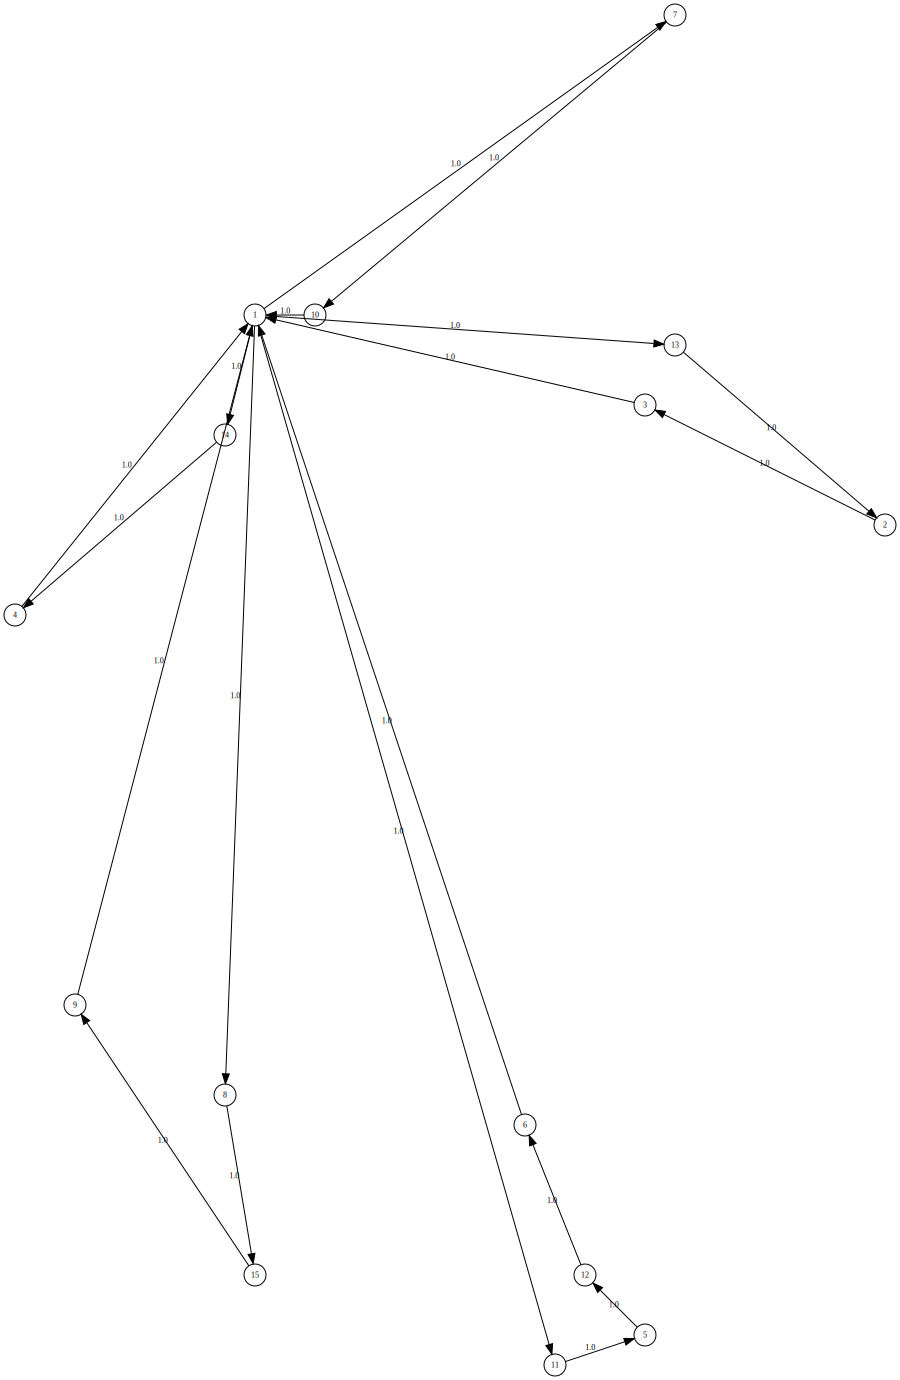

In [24]:
display(SVG(filename=basename+'_sol.svg'))
